In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:16pt;}
div.text_cell_render.rendered_html{font-size:16pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:16pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
table.dataframe{font-size:16px;}
</style>
"""))

In [3]:
import os # 모델 저장할 폴더가 있는지 여부와 폴더 생성
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# 1. 데이터셋 생성(seaborn) 및 전처리
- x,y(라벨인코딩-원핫인코딩) 분리 -> train 과 test셋 분리(8:2)

In [24]:
iris = sns.load_dataset('iris')
X_iris = iris.iloc[:, :-1].values
y_iris = iris.iloc[:, -1] 
X_iris.shape, y_iris.shape

((150, 4), (150,))

In [25]:
Y_iris = pd.get_dummies(y_iris).to_numpy()
Y_iris

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X_iris,
                                                   Y_iris,
                                                   train_size=0.8,
                                                   stratify=Y_iris, # 층화
                                                   random_state=12)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

# 2. 모델 구성
- 입력4 -> 출력 3, layer5: 4->64->128->50->30->3

In [27]:
model = Sequential()
model.add(Input(4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                320       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                6450      
                                                                 
 dense_8 (Dense)             (None, 30)                1530      
                                                                 
 dense_9 (Dense)             (None, 3)                 93        
                                                                 
Total params: 16,713
Trainable params: 16,713
Non-trai

# 3. 모델 학습과정 설정

In [28]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
            )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder \
        + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                filepath= file,
                monitor='val_accuracy',
                save_best_only=True,
                mode = 'max',
                verbose=1)

CPU times: total: 0 ns
Wall time: 5.77 ms


# 4. 모델학습(Earlystopping, ModelCheckpoint추가)

In [29]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로 
                verbose=0, # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss:1.0783, acc:0.4375, val_loss:0.9738, val_acc:0.6667

Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to ./model\iris-001-loss0.9738-acc0.6667.h5

Epoch 2: val_accuracy did not improve from 0.66667

Epoch 3: val_accuracy did not improve from 0.66667

Epoch 4: val_accuracy did not improve from 0.66667
5번째 loss:0.8824, acc:0.6250, val_loss:0.8253, val_acc:0.6667

Epoch 5: val_accuracy did not improve from 0.66667

Epoch 6: val_accuracy did not improve from 0.66667

Epoch 7: val_accuracy improved from 0.66667 to 0.75000, saving model to ./model\iris-007-loss0.7599-acc0.7500.h5

Epoch 8: val_accuracy did not improve from 0.75000

Epoch 9: val_accuracy did not improve from 0.75000
10번째 loss:0.7142, acc:0.7083, val_loss:0.6656, val_acc:0.7083

Epoch 10: val_accuracy did not improve from 0.75000

Epoch 11: val_accuracy did not improve from 0.75000

Epoch 12: val_accuracy did not improve from 0.75000

Epoch 13: val_accuracy did not improve from 0.75000

Epoch 14: val_

120번째 loss:0.0821, acc:0.9896, val_loss:0.0478, val_acc:1.0000

Epoch 120: val_accuracy did not improve from 1.00000

Epoch 121: val_accuracy did not improve from 1.00000

Epoch 122: val_accuracy did not improve from 1.00000

Epoch 123: val_accuracy did not improve from 1.00000

Epoch 124: val_accuracy did not improve from 1.00000
125번째 loss:0.1030, acc:0.9688, val_loss:0.0484, val_acc:1.0000

Epoch 125: val_accuracy did not improve from 1.00000

Epoch 126: val_accuracy did not improve from 1.00000

Epoch 127: val_accuracy did not improve from 1.00000

Epoch 128: val_accuracy did not improve from 1.00000

Epoch 129: val_accuracy did not improve from 1.00000
130번째 loss:0.1080, acc:0.9688, val_loss:0.0514, val_acc:1.0000

Epoch 130: val_accuracy did not improve from 1.00000

Epoch 131: val_accuracy did not improve from 1.00000

Epoch 132: val_accuracy did not improve from 1.00000

Epoch 133: val_accuracy did not improve from 1.00000

Epoch 134: val_accuracy did not improve from 1.00000
1

# 5. 모델평가
- 시각화, 현재모델과 저장된 최고의 모델 평가

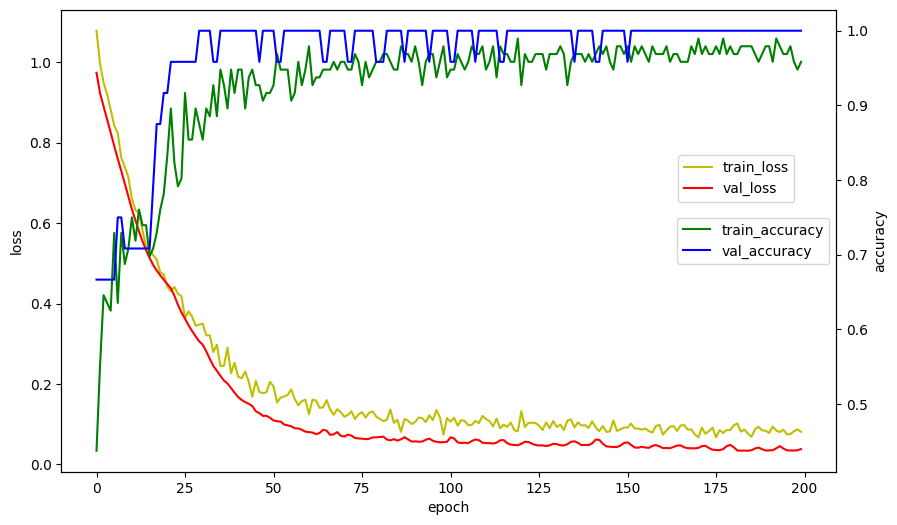

In [30]:
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [31]:
loss_and_acc =model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.0107, accuracy:1.0000


# 6. 모델예측/저장

In [32]:
real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

1/1 [==============================] - 0s 50ms/step


predict,0,1,2
real,,,
0,10,0,0
1,0,10,0
2,0,0,10


In [33]:
X_iris[0]

array([5.1, 3.5, 1.4, 0.2])

In [38]:
model2 = load_model('model/iris-030-loss0.3061-acc1.0000.h5')
loss_and_acc1=model2.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:0.2791, accuracy:1.0000
